## Simulation for 1 point source

In this simulation, I add visibilities from 1 pntsrc and output a UVdata object using hera_sim. Then I make a power spectrum plot using hera_pspec

In [1]:
from hera_sim.simulate import Simulator
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uvtools

import hera_pspec as hp
from pyuvdata import UVData

from hera_sim.noise import HERA_Tsky_mdl
from hera_sim.data import DATA_PATH

/home/anks/.local/lib/python3.7/site-packages/hera_sim-0.1.0-py3.7.egg/hera_sim/visibilities/__init__.py:22: UserWarning: healvis failed to import.
  warnings.warn("healvis failed to import.")
/home/anks/.local/lib/python3.7/site-packages/hera_sim-0.1.0-py3.7.egg/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


In [2]:
sim = Simulator(
    n_freq = 128,
    n_times = 200,
    antennas = {
        0: (20.0, 20.0, 0),
        1: (50.0, 50.0, 0),
        },
    no_autos=True,   # model only one baseline
    integration_time=3600*16./200., # roughly 16 hours of total time
)

In [3]:
sim.antpos

{0: array([ 2.00000000e+01,  2.00000000e+01, -4.53549731e-09]),
 1: array([ 5.00000000e+01,  5.00000000e+01, -4.40831371e-09])}

In [4]:
print(sim.data.get_antpairs())
print(sim.data.get_ants())
print(sim.data.Nbls)
print(sim.data.data_array.shape)

[(0, 1)]
[0 1]
1
(200, 1, 128, 1)


In [5]:
def waterfall(
    vis, freq=sim.data.freq_array[0]/1e6, lsts=sim.data.lst_array, 
    vmax=None, vrange=None, title=None,
):
    """
    A wrapper around the uvtools' waterfall function providing some
    extra labelling and plot adjustment.
    """
    fig, ax = plt.subplots(
        2,1, sharex=True, sharey=True, figsize=(12,10)
    )
    
    if title is not None:
        ax[0].set_title(title, fontsize=12)
    plt.sca(ax[0])
    uvtools.plot.waterfall(
        vis[:,0,:,0], mode='log', mx=vmax, drng=vrange,
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label=r'log$_{10}$(Vis/Jy)')
    plt.ylabel("LST", fontsize=12)
    
    plt.sca(ax[1])
    uvtools.plot.waterfall(
        vis[:,0,:,0], 
        mode='phs',
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label='Phase [rad]')
    plt.xlabel("Frequency [MHz]", fontsize=12)
    plt.ylabel("LST", fontsize=12)


### Adding 1 point source

In [6]:
sim.add_foregrounds(
    "pntsrc_foreground",
    nsrcs = 5000
)

In [7]:
sim.data.data_array.shape

(200, 1, 128, 1)

In [8]:
print(sim.data.freq_array.shape)

(1, 128)


In [9]:
log_freq = np.log10(sim.data.freq_array[0,:])

In [10]:
log_data = np.log10(np.abs(sim.data.data_array[0,0,:,0]))

#### Plotting log Freq against log Data

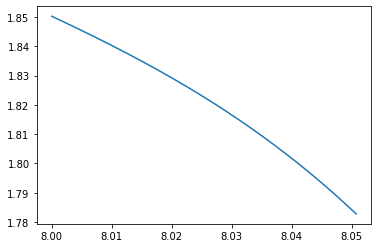

In [11]:
plt.plot(log_freq,log_data)

#### Plotting single frequency channel

Text(0.5, 0, 'Time')

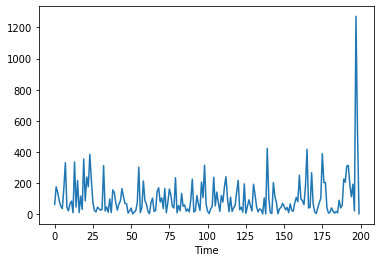

In [12]:
plt.plot(np.abs(sim.data.data_array[:,0,100,0]))
plt.xlabel("Time")

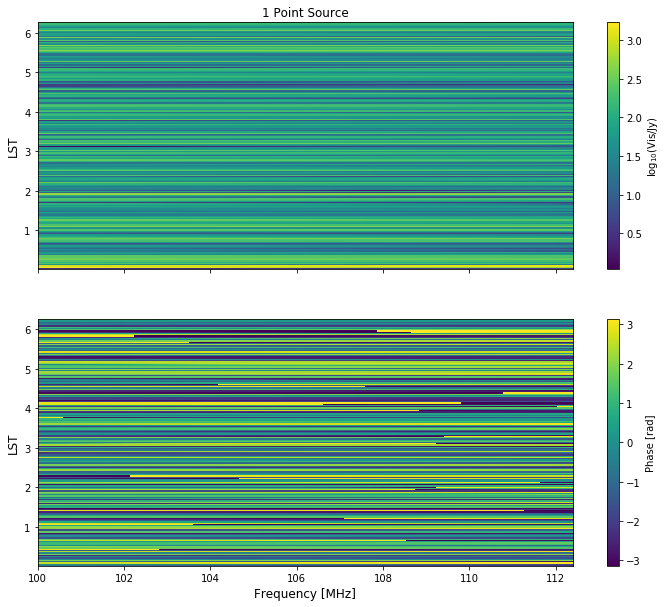

In [13]:
waterfall(sim.data.data_array, title='1 Point Source')

### Plot Power Spectrum

In [14]:
type(sim.data)

pyuvdata.uvdata.UVData

In [15]:
# Load into UVData objects
uvd = sim.data

In [16]:
uvd.metadata_only

False

In [17]:
uvd.get_pols()

['xx']

In [18]:
uvd.data_array.shape

(200, 1, 128, 1)

In [19]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()

In [20]:
# Load beam model
beamfile = '../data/HERA_NF_dipole_power.beamfits'

uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)


In [21]:
# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [22]:
# Specify which baselines to include
baselines = [(0,1)]

In [23]:
# we will use the baselines list to produce power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across spectral window between channels 600 -- 700 with identity weighting and a blackman-harris taper
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')],  
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (0, 128)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Text(0.5, 1.0, 'spw : 0, blpair : ((0, 1), (0, 1)), pol : xx')

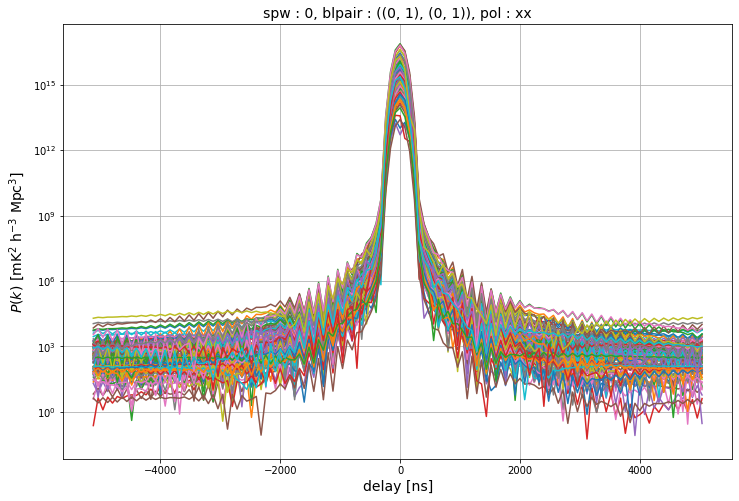

In [24]:
# (bl1, bl2) pair: ((24, 25), (24, 25))
# plot power spectrum of spectral window 0
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp =((0, 1), (0, 1))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

In [25]:
help(sim.add_noise)

Help on method add_noise in module hera_sim.simulate:

add_noise(model, **kwargs) method of hera_sim.simulate.Simulator instance
    Add thermal noise to the visibilities.
    
    Args:
        model (str or callable): either a string name of a model function existing in :mod:`~hera_sim.noise`,
            or a callable which has the signature ``fnc(lsts, fqs, bl_len_ns, omega_p, **kwargs)``.
        ret_vis (bool, optional): whether to return the visibilities that are being added to to the base
            data as a new array. Default False.
        add_vis (bool, optional): whether to add the calculated visibilities to the underlying data array.
            Default True.
        **kwargs: keyword arguments sent to the noise model function, other than `lsts`, `fqs` and `bl_len_ns`.

